<a href="https://colab.research.google.com/github/Jules-gatete/ML-Techniques-I---CHATBOT/blob/main/chatbot_cleaned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔧 STEP 1: Install Dependencies

In [1]:
!pip install --upgrade datasets -q
!pip install tensorflow transformers evaluate seaborn nltk wordcloud -q
!pip install --upgrade datasets -q
!pip install tensorflow transformers evaluate seaborn nltk wordcloud rouge_score -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 15.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6

# 📦 STEP 2: Import Libraries


In [2]:
# 📦 STEP 2: Import Libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
import string
import numpy as np
from datasets import load_dataset, Dataset
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from transformers import T5Tokenizer, TFT5ForConditionalGeneration, DataCollatorForSeq2Seq, create_optimizer, Trainer, TrainingArguments
import tensorflow as tf

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)

True

# 📊 STEP 3: Load the Dataset


In [3]:
dataset = load_dataset("abamerdeen/insurance-qa")
print(dataset)

mistralSingleV4_train.json:   0%|          | 0.00/5.42M [00:00<?, ?B/s]

mistralSingleV4_val.json:   0%|          | 0.00/310k [00:00<?, ?B/s]

mistralSingleV4_test.json:   0%|          | 0.00/650k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2988 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/175 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/351 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['context', 'question', 'answer'],
        num_rows: 2988
    })
    validation: Dataset({
        features: ['context', 'question', 'answer'],
        num_rows: 175
    })
    test: Dataset({
        features: ['context', 'question', 'answer'],
        num_rows: 351
    })
})


In [4]:
# Convert to DataFrame for EDA
df = pd.DataFrame(dataset['train'])
df = pd.DataFrame(dataset['test'])
df = pd.DataFrame(dataset['validation'])

df.head()

,context,question,answer
0,,how does life insurance work if i die?,"Life insurance, such as the Vital Assurance po..."
1,,what is life insurance death benefit?,The Life Insurance Death Benefit is a key feat...
2,,how many beneficiaries can life insurance have?,"Under the Total Care Plan of Vital Assurance, ..."
3,,how much does life insurance cost on average?,"The cost of life insurance, specifically the L..."
4,,what is life insurance?,Life insurance is a contract between an indivi...


In [5]:
# Show basic stats
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175 entries, 0 to 174
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   context   175 non-null    object
 1   question  175 non-null    object
 2   answer    175 non-null    object
dtypes: object(3)
memory usage: 4.2+ KB
None
  context                                         question  \
0                   how does life insurance work if i die?   
1                    what is life insurance death benefit?   
2          how many beneficiaries can life insurance have?   
3            how much does life insurance cost on average?   
4                                  what is life insurance?   

                                              answer  
0  Life insurance, such as the Vital Assurance po...  
1  The Life Insurance Death Benefit is a key feat...  
2  Under the Total Care Plan of Vital Assurance, ...  
3  The cost of life insurance, specifically the L...  
4  Life insur

📊 STEP 4: Exploratory Data Analysis (EDA)


In [6]:
# Ensure no NaN values for EDA
df['question'] = df['question'].fillna("")
df['answer'] = df['answer'].fillna("")

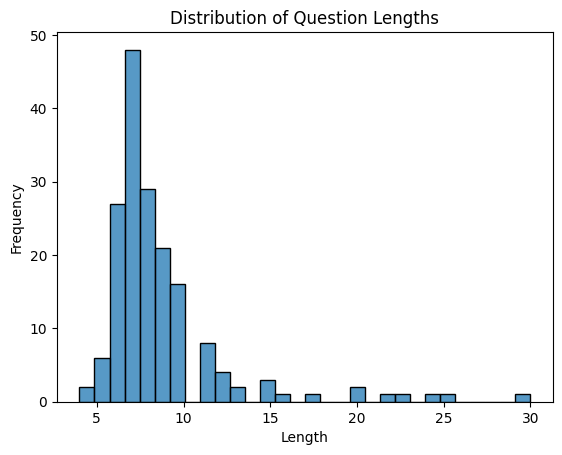

In [7]:
# Question length distribution
df['question_length'] = df['question'].apply(lambda x: len(x.split()))
sns.histplot(df['question_length'], bins=30)
plt.title("Distribution of Question Lengths")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

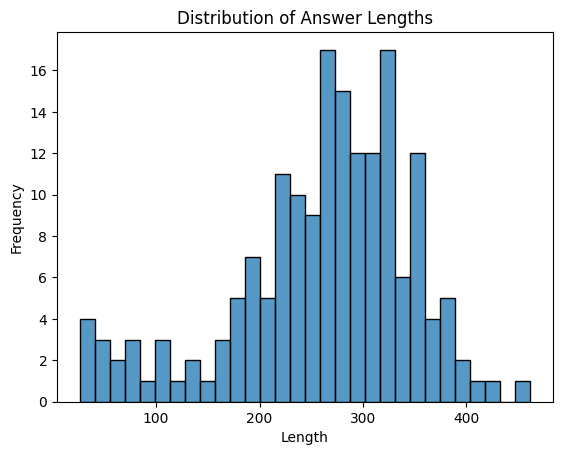

In [8]:
# Answer length distribution
df['answer_length'] = df['answer'].apply(lambda x: len(x.split()))
sns.histplot(df['answer_length'], bins=30)
plt.title("Distribution of Answer Lengths")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

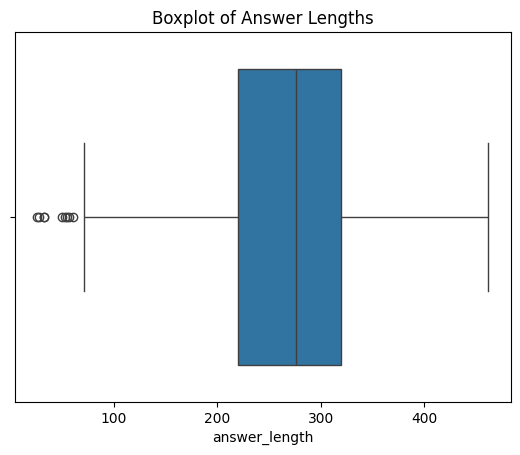

In [9]:
# Most common answer lengths
sns.boxplot(data=df, x='answer_length')
plt.title("Boxplot of Answer Lengths")
plt.show()



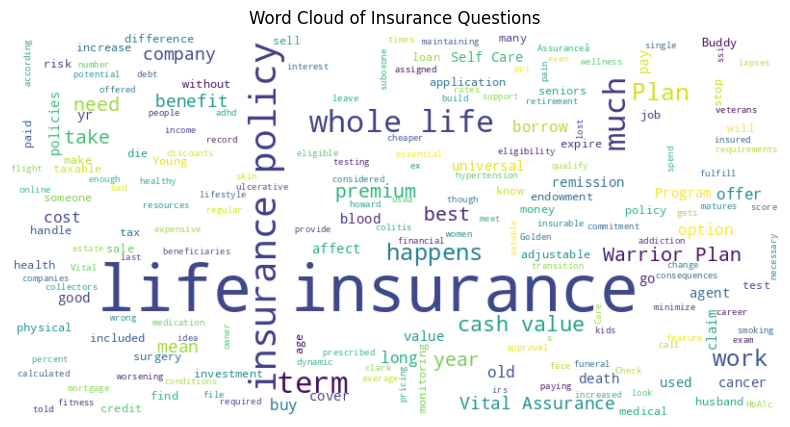

In [10]:
# 🆕 Word cloud of top terms in questions
from wordcloud import WordCloud
text = ' '.join(df['question'].astype(str).tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Insurance Questions")
plt.show()

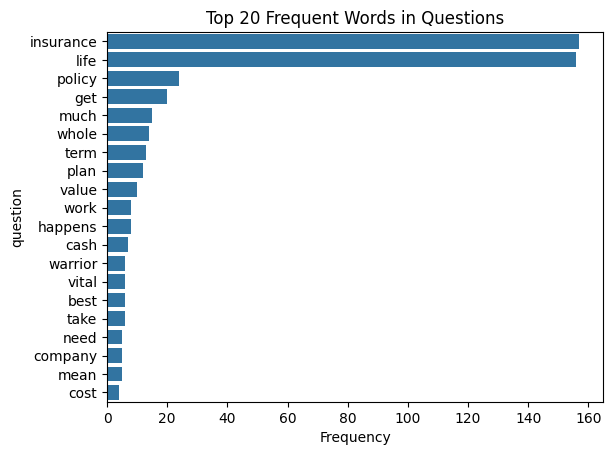

In [11]:
# Top 20 frequent words in questions (excluding stopwords)
stop_words = set(stopwords.words('english'))

def clean_text(text):
    if not isinstance(text, str):
        return []
    text = re.sub(r'[^\w\s]', '', text.lower())
    tokens = word_tokenize(text)
    return [word for word in tokens if word not in stop_words]

all_words = df['question'].apply(clean_text).explode()
freq_words = all_words.value_counts().head(20)

sns.barplot(x=freq_words.values, y=freq_words.index)
plt.title("Top 20 Frequent Words in Questions")
plt.xlabel("Frequency")
plt.show()

🔍 STEP 5: Preprocessing Function


In [12]:
def preprocess(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(f"[{re.escape(string.punctuation)}]", '', text)
    return text.strip()

# Apply preprocessing
df['question'] = df['question'].fillna("")
df['answer'] = df['answer'].fillna("")
df['clean_question'] = df['question'].apply(preprocess)
df['clean_answer'] = df['answer'].apply(preprocess)

# Check for missing values
print("Missing values:\n", df[['clean_question', 'clean_answer']].isnull().sum())

# Save preprocessed data if file doesn't exist
import os
if not os.path.exists("processed_insurance_qa.csv"):
    df[['clean_question', 'clean_answer']].to_csv("processed_insurance_qa.csv", index=False)

Missing values:
 clean_question    0
clean_answer      0
dtype: int64


🧠 STEP 6: Tokenization & Dataset Preparation


In [13]:
from transformers import T5Tokenizer
from datasets import Dataset

tokenizer = T5Tokenizer.from_pretrained('t5-small', legacy=False)
max_input_length = 64
max_target_length = 128

def tokenize_function(example):
    # T5 expects input text to start with a task prefix like "question: "
    input_texts = ["question: " + q for q in example["clean_question"]]
    target_texts = example["clean_answer"]

    model_inputs = tokenizer(
        input_texts,
        max_length=64,
        padding="max_length",
        truncation=True
    )

    # Tokenize targets and replace padding token IDs with -100
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            target_texts,
            max_length=128,
            padding="max_length",
            truncation=True
        )

    labels["input_ids"] = [
        [(token if token != tokenizer.pad_token_id else -100) for token in label]
        for label in labels["input_ids"]
    ]

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs





tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [14]:
# Convert DataFrame to Dataset and split
df = df.dropna(subset=['clean_question', 'clean_answer']).reset_index(drop=True)
hf_dataset = Dataset.from_pandas(df[['clean_question', 'clean_answer']])
split_dataset = hf_dataset.train_test_split(test_size=0.1, seed=42)

train_ds = split_dataset['train']
val_ds = split_dataset['test']

# Tokenize datasets
tokenized_train_ds = train_ds.map(tokenize_function, batched=True, remove_columns=['clean_question', 'clean_answer'])
tokenized_val_ds = val_ds.map(tokenize_function, batched=True, remove_columns=['clean_question', 'clean_answer'])

# Debug: Verify tokenized dataset
print("Sample from tokenized_train_ds:", tokenized_train_ds[0])
print("Features in tokenized_train_ds:", tokenized_train_ds.features)

Map:   0%|          | 0/157 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3959: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/18 [00:00<?, ? examples/s]

Sample from tokenized_train_ds: {'input_ids': [822, 10, 149, 231, 280, 958, 54, 3, 23, 129, 406, 3, 9, 1722, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': [8, 251, 81, 8, 866, 13, 280, 958, 25, 54, 129, 406, 3, 9, 1722, 19, 59, 21119, 2799, 8, 1030, 937, 33, 81, 8, 315, 1308, 13, 3792, 347, 11, 8, 2411, 2591, 25, 54, 854, 45, 21, 3421, 21, 280, 1189, 25, 54, 854, 2591, 45, 910, 2313, 12, 5580, 2313, 16, 944, 2313, 26006, 7, 983, 34, 405, 59, 11610, 823, 3, 9, 1722, 6498, 19, 831, 12, 3442, 48, 2591, 2459, 8, 2883, 866, 13, 280, 958, 25, 54, 129, 406, 3, 9, 1722, 1178, 36, 4187, 45, 8, 937, 251, 1, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -1

📦 STEP 7: Prepare Dataset for TensorFlow


In [15]:
# 📦 STEP 7: Prepare Dataset for TensorFlow
from transformers import TFT5ForConditionalGeneration, DataCollatorForSeq2Seq, create_optimizer
import tensorflow as tf
import numpy as np

# Initialize model and data collator
model = TFT5ForConditionalGeneration.from_pretrained('t5-small')
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model, return_tensors="tf")

# ✅ Rebuild TensorFlow datasets using proper tuple (X, y) structure
tf_train_dataset = tokenized_train_ds.to_tf_dataset(
    columns=["input_ids", "attention_mask", "labels"],
    shuffle=True,
    batch_size=8,
    collate_fn=data_collator
).map(lambda x: ({"input_ids": x["input_ids"], "attention_mask": x["attention_mask"]}, x["labels"]))

tf_val_dataset = tokenized_val_ds.to_tf_dataset(
    columns=["input_ids", "attention_mask", "labels"],
    shuffle=False,
    batch_size=8,
    collate_fn=data_collator
).map(lambda x: ({"input_ids": x["input_ids"], "attention_mask": x["attention_mask"]}, x["labels"]))



config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFT5ForConditionalGeneration.

All the weights of TFT5ForConditionalGeneration were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


🏋️‍♂️ STEP 8: Train the Model

In [16]:
# 🧠 STEP 8: Train the Model with Custom EarlyStopping
class CustomEarlyStopping(tf.keras.callbacks.Callback):
    def __init__(self, monitor='val_loss', patience=3, restore_best_weights=True):
        super().__init__()
        self.monitor = monitor
        self.patience = patience
        self.restore_best_weights = restore_best_weights
        self.best_weights = None
        self.best_loss = np.inf
        self.best_epoch = 0

    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get(self.monitor)
        if current_loss is None:
            return
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.best_epoch = epoch
            if self.restore_best_weights:
                self.best_weights = self.model.get_weights()
        elif epoch - self.best_epoch >= self.patience:
            print(f"\nEarly stopping at epoch {epoch+1}: {self.monitor} did not improve for {self.patience} epochs.")
            self.model.stop_training = True
            if self.restore_best_weights and self.best_weights is not None:
                print("Restoring best weights.")
                self.model.set_weights(self.best_weights)

# Compile the model
num_train_steps = len(tf_train_dataset) * 5
optimizer, schedule = create_optimizer(
    init_lr=3e-4,
    num_warmup_steps=0,
    num_train_steps=num_train_steps
)
model.compile(optimizer=optimizer, loss=model.compute_loss)

# Recreate optimizer and compile the model
optimizer, schedule = create_optimizer(
    init_lr=3e-4,
    num_warmup_steps=0,
    num_train_steps=len(tf_train_dataset) * 5
)

model.compile(optimizer=optimizer, loss=model.compute_loss)

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

# 🩹 Patch all 3 required methods
EarlyStopping._implements_train_batch_hooks = lambda self: False
EarlyStopping._implements_test_batch_hooks = lambda self: False
EarlyStopping._implements_predict_batch_hooks = lambda self: False

# ✅ Define EarlyStopping as usual
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)


In [18]:
# Define EarlyStopping callback
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# ✅ Train the model without NoneType label error
history = model.fit(
    tf_train_dataset,
    validation_data=tf_val_dataset,
    epochs=5,
    callbacks=[early_stopping]
)


Epoch 1/5


ValueError: in user code:

    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py", line 1398, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py", line 1381, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py", line 1370, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.11/dist-packages/transformers/modeling_tf_utils.py", line 1652, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/tmp/__autograph_generated_fileegun60ge.py", line 40, in tf__run_call_with_unpacked_inputs
        raise
    File "/tmp/__autograph_generated_file23tvl4uz.py", line 91, in tf__call
        decoder_outputs = ag__.converted_call(ag__.ld(self).decoder, (ag__.ld(decoder_input_ids),), dict(attention_mask=ag__.ld(decoder_attention_mask), encoder_hidden_states=ag__.ld(hidden_states), encoder_attention_mask=ag__.ld(attention_mask), inputs_embeds=ag__.ld(decoder_inputs_embeds), head_mask=ag__.ld(decoder_head_mask), past_key_values=ag__.ld(past_key_values), use_cache=ag__.ld(use_cache), output_attentions=ag__.ld(output_attentions), output_hidden_states=ag__.ld(output_hidden_states), return_dict=ag__.ld(return_dict), training=ag__.ld(training)), fscope)
    File "/tmp/__autograph_generated_fileegun60ge.py", line 40, in tf__run_call_with_unpacked_inputs
        raise
    File "/tmp/__autograph_generated_fileg5dtmvle.py", line 65, in tf__call
        ag__.if_stmt(ag__.and_(lambda: ag__.ld(input_ids) is not None, lambda: ag__.ld(inputs_embeds) is not None), if_body_2, else_body_2, get_state_2, set_state_2, ('input_ids', 'input_shape'), 2)
    File "/tmp/__autograph_generated_fileg5dtmvle.py", line 62, in else_body_2
        ag__.if_stmt(ag__.ld(input_ids) is not None, if_body_1, else_body_1, get_state_1, set_state_1, ('input_ids', 'input_shape'), 2)
    File "/tmp/__autograph_generated_fileg5dtmvle.py", line 59, in else_body_1
        ag__.if_stmt(ag__.ld(inputs_embeds) is not None, if_body, else_body, get_state, set_state, ('input_shape',), 1)
    File "/tmp/__autograph_generated_fileg5dtmvle.py", line 56, in else_body
        raise ag__.converted_call(ag__.ld(ValueError), (f'You have to specify either {ag__.ld(err_msg_prefix)}input_ids or {ag__.ld(err_msg_prefix)}inputs_embeds',), None, fscope)

    ValueError: Exception encountered when calling layer 'tft5_for_conditional_generation' (type TFT5ForConditionalGeneration).
    
    in user code:
    
        File "/usr/local/lib/python3.11/dist-packages/transformers/modeling_tf_utils.py", line 1395, in run_call_with_unpacked_inputs  *
            return func(self, **unpacked_inputs)
        File "/usr/local/lib/python3.11/dist-packages/transformers/models/t5/modeling_tf_t5.py", line 1455, in call  *
            decoder_outputs = self.decoder(
        File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/utils/traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "/tmp/__autograph_generated_fileegun60ge.py", line 40, in tf__run_call_with_unpacked_inputs
            raise
        File "/tmp/__autograph_generated_fileg5dtmvle.py", line 65, in tf__call
            ag__.if_stmt(ag__.and_(lambda: ag__.ld(input_ids) is not None, lambda: ag__.ld(inputs_embeds) is not None), if_body_2, else_body_2, get_state_2, set_state_2, ('input_ids', 'input_shape'), 2)
        File "/tmp/__autograph_generated_fileg5dtmvle.py", line 62, in else_body_2
            ag__.if_stmt(ag__.ld(input_ids) is not None, if_body_1, else_body_1, get_state_1, set_state_1, ('input_ids', 'input_shape'), 2)
        File "/tmp/__autograph_generated_fileg5dtmvle.py", line 59, in else_body_1
            ag__.if_stmt(ag__.ld(inputs_embeds) is not None, if_body, else_body, get_state, set_state, ('input_shape',), 1)
        File "/tmp/__autograph_generated_fileg5dtmvle.py", line 56, in else_body
            raise ag__.converted_call(ag__.ld(ValueError), (f'You have to specify either {ag__.ld(err_msg_prefix)}input_ids or {ag__.ld(err_msg_prefix)}inputs_embeds',), None, fscope)
    
        ValueError: Exception encountered when calling layer 'decoder' (type TFT5MainLayer).
        
        in user code:
        
            File "/usr/local/lib/python3.11/dist-packages/transformers/modeling_tf_utils.py", line 1395, in run_call_with_unpacked_inputs  *
                return func(self, **unpacked_inputs)
            File "/usr/local/lib/python3.11/dist-packages/transformers/models/t5/modeling_tf_t5.py", line 754, in call  *
                raise ValueError(f"You have to specify either {err_msg_prefix}input_ids or {err_msg_prefix}inputs_embeds")
        
            ValueError: You have to specify either decoder_input_ids or decoder_inputs_embeds
        
        
        Call arguments received by layer 'decoder' (type TFT5MainLayer):
          • input_ids=None
          • attention_mask=None
          • encoder_hidden_states=tf.Tensor(shape=(None, 64, 512), dtype=float32)
          • encoder_attention_mask=tf.Tensor(shape=(None, 64), dtype=int32)
          • inputs_embeds=None
          • head_mask=None
          • encoder_head_mask=None
          • past_key_values=None
          • use_cache=True
          • output_attentions=False
          • output_hidden_states=False
          • return_dict=True
          • training=True
    
    
    Call arguments received by layer 'tft5_for_conditional_generation' (type TFT5ForConditionalGeneration):
      • input_ids={'input_ids': 'tf.Tensor(shape=(None, 64), dtype=int64)', 'attention_mask': 'tf.Tensor(shape=(None, 64), dtype=int64)'}
      • attention_mask=None
      • decoder_input_ids=None
      • decoder_attention_mask=None
      • head_mask=None
      • decoder_head_mask=None
      • encoder_outputs=None
      • past_key_values=None
      • inputs_embeds=None
      • decoder_inputs_embeds=None
      • labels=None
      • use_cache=None
      • output_attentions=None
      • output_hidden_states=None
      • return_dict=None
      • training=True


In [ ]:
# ✅ Train the model
history = model.fit(
    tf_train_dataset,
    validation_data=tf_val_dataset,
    epochs=5,
    callbacks=[early_stopping]
)

Epoch 1/5


AttributeError: in user code:

    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py", line 1398, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.11/dist-packages/transformers/modeling_tf_utils.py", line 1568, in compute_loss  *
        return super().compute_loss(*args, **kwargs)
    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/training.py", line 1206, in compute_loss  **
        return self.compiled_loss(
    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/compile_utils.py", line 275, in __call__
        y_t, y_p, sw = match_dtype_and_rank(y_t, y_p, sw)
    File "/usr/local/lib/python3.11/dist-packages/tf_keras/src/engine/compile_utils.py", line 854, in match_dtype_and_rank
        if (y_t.dtype.is_floating and y_p.dtype.is_floating) or (

    AttributeError: 'NoneType' object has no attribute 'dtype'


In [ ]:
model.save_pretrained("t5_insurance_chatbot_model")
tokenizer.save_pretrained("t5_insurance_chatbot_model")


('t5_insurance_chatbot_model/tokenizer_config.json',
 't5_insurance_chatbot_model/special_tokens_map.json',
 't5_insurance_chatbot_model/spiece.model',
 't5_insurance_chatbot_model/added_tokens.json')

In [ ]:
# history = model.fit(...) # Remove or comment out this line

# Show all metrics collected during training
print("Available metrics:")
for key in history.history:
    print(f"{key}: {history.history[key]}")

Available metrics:
loss: [3.29348087310791, 2.734257936477661, 2.576707124710083]
val_loss: [2.565584897994995, 2.3584861755371094, 2.3056800365448]


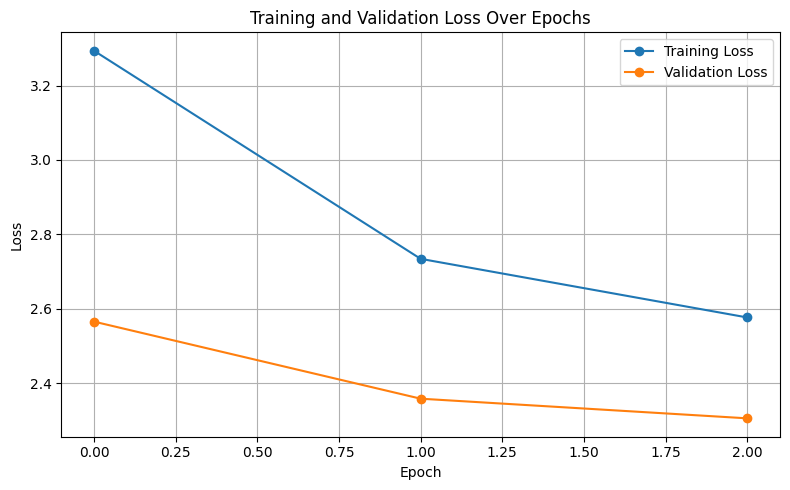

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import evaluate
from tqdm import tqdm

# Load metrics
bleu_metric = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")
f1_metric = evaluate.load("f1")


# decode predictions
def generate_answers(batch):
    inputs = tokenizer(batch["clean_question"], return_tensors="tf", padding=True, truncation=True)
    output_sequences = model.generate(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        max_length=128
    )
    return tokenizer.batch_decode(output_sequences, skip_special_tokens=True)

# Prepare ground truth and predictions
predictions = []
references = []

# Loop through validation examples
for example in tqdm(val_ds, desc="Evaluating"):
    pred = generate_answers({"clean_question": example["clean_question"]})[0]
    ref = example["clean_answer"]

    predictions.append(pred)
    references.append(ref)


Evaluating:  63%|██████▎   | 188/299 [1:30:02<49:59, 27.02s/it]

✅ 4. 📊 Compute Metrics

#BLEU



In [ ]:
bleu_result = bleu_metric.compute(predictions=predictions, references=[[ref] for ref in references])
print("BLEU Score:", bleu_result["bleu"])

##ROUGE

In [ ]:
rouge_result = rouge_metric.compute(predictions=predictions, references=references)
print("ROUGE-L:", rouge_result["rougeL"])

##F1
Note: evaluate’s F1 is for classification tasks. For Q&A, we compute token-level F1 manually:

In [ ]:
from sklearn.metrics import f1_score
import numpy as np

def compute_token_f1(preds, refs):
    f1_scores = []
    for p, r in zip(preds, refs):
        p_tokens = p.lower().split()
        r_tokens = r.lower().split()
        common = set(p_tokens) & set(r_tokens)

        if len(p_tokens) == 0 or len(r_tokens) == 0:
            f1_scores.append(0)
            continue

        precision = len(common) / len(p_tokens)
        recall = len(common) / len(r_tokens)

        if precision + recall == 0:
            f1_scores.append(0)
        else:
            f1 = 2 * (precision * recall) / (precision + recall)
            f1_scores.append(f1)

    return np.mean(f1_scores)

token_f1 = compute_token_f1(predictions, references)
print("Token-level F1 Score:", token_f1)
